In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [21]:
class Neural_network:
    def __init__(self, layers):
        self.layers = layers
        # self.weights = [np.random.randn(layers[i], layers[i+1]) * 0.05 for i in range(len(layers) - 1)]
        self.weights = [np.random.randn(layers[i], layers[i+1]) * np.sqrt(2. / layers[i]) for i in range(len(layers) - 1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(len(layers) - 1)]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):  # Assumes x is already sigmoid(x)
        return x * (1 - x)
    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            net_input = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activations.append(self.sigmoid(net_input))
        return activations

    def backpropagation(self, X, y, activations, learning_rate):
        error = y - activations[-1]
        delta = error * self.relu_derivative(activations[-1])

        for i in range(len(self.weights) - 1, -1, -1):
            self.weights[i] += learning_rate * np.dot(activations[i].T, delta)
            self.biases[i] += learning_rate * np.sum(delta, axis=0, keepdims=True)
            if i != 0:
                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(activations[i])

    def mean_absolute_error(self, y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def train(self, X_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            activations = self.forward(X_train)
            self.backpropagation(X_train, y_train, activations, learning_rate)
            if (epoch + 1) % 100 == 0:
                loss = self.mean_squared_error(y_train, activations[-1])
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward(X)[-1]


In [4]:
data = pd.read_csv('car_price.csv')

In [5]:
data

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats
...,...,...,...,...,...,...,...,...,...,...
5507,5507,BMW X1 sDrive 20d xLine,28.90 Lakh,"45,000 kms",Diesel,Automatic,1st Owner,2018,2995 cc,7 Seats
5508,5508,BMW M Series M4 Coupe,64.90 Lakh,"29,000 kms",Petrol,Automatic,2nd Owner,2015,1968 cc,5 Seats
5509,5509,Jaguar XF 2.2 Litre Luxury,13.75 Lakh,"90,000 kms",Diesel,Automatic,2nd Owner,2013,2755 cc,5 Seats
5510,5510,BMW 7 Series 730Ld,29.90 Lakh,"79,000 kms",Diesel,Automatic,3rd Owner,2015,2967 cc,6 Seats


In [6]:
# Explore categorical features and their unique values
categorical_features = ['car_name', 'transmission', 'fuel_Type','ownership'] # Example features
for col in categorical_features:
    if col in data.columns:
        print(f"\nUnique values in '{col}':")
        print(data[col].unique()[:20]) # Print only the first 20 unique values


Unique values in 'car_name':
['Jeep Compass 2.0 Longitude Option BSIV' 'Renault Duster RXZ Turbo CVT'
 'Toyota Camry 2.5 G' 'Honda Jazz VX CVT'
 'Volkswagen Polo 1.2 MPI Highline' 'Volkswagen Vento 1.2 TSI Highline AT'
 'Volkswagen Vento 1.2 TSI Highline Plus AT' 'Honda WR-V VX Diesel'
 'Honda City i VTEC CVT SV' 'Renault Duster Petrol RXS CVT'
 'Maruti Baleno 1.2 Alpha' 'Mahindra XUV300 W6'
 'Jeep Compass 1.4 Limited Plus BSIV' 'Honda City V MT'
 'Hyundai Grand i10 AT Asta' 'Hyundai i20 1.4 Asta'
 'Maruti Ciaz 1.4 Delta' 'Nissan Micra XL Optional'
 'Maruti Ciaz Alpha Automatic BSIV' 'Maruti Swift Dzire VXI']

Unique values in 'transmission':
['Manual' 'Automatic']

Unique values in 'ownership':
['1st Owner' '2nd Owner' '3rd Owner' '4th Owner' '5th Owner' '0th Owner']


In [7]:
data.shape

(5512, 10)

In [8]:
print(data.head())
print("----------------------")
print(data.info())
print("----------------------")
print(data.describe())

   Unnamed: 0                                car_name car_prices_in_rupee  \
0           0  Jeep Compass 2.0 Longitude Option BSIV          10.03 Lakh   
1           1            Renault Duster RXZ Turbo CVT          12.83 Lakh   
2           2                      Toyota Camry 2.5 G          16.40 Lakh   
3           3                       Honda Jazz VX CVT           7.77 Lakh   
4           4        Volkswagen Polo 1.2 MPI Highline           5.15 Lakh   

   kms_driven fuel_type transmission  ownership  manufacture   engine    Seats  
0  86,226 kms    Diesel       Manual  1st Owner         2017  1956 cc  5 Seats  
1  13,248 kms    Petrol    Automatic  1st Owner         2021  1330 cc  5 Seats  
2  60,343 kms    Petrol    Automatic  1st Owner         2016  2494 cc  5 Seats  
3  26,696 kms    Petrol    Automatic  1st Owner         2018  1199 cc  5 Seats  
4  69,414 kms    Petrol       Manual  1st Owner         2016  1199 cc  5 Seats  
----------------------
<class 'pandas.core.frame.Da

In [9]:
data.isnull().sum()

,0
Unnamed: 0,0
car_name,0
car_prices_in_rupee,0
kms_driven,0
fuel_type,0
transmission,0
ownership,0
manufacture,0
engine,0
Seats,0


In [10]:
print(data.fuel_type.value_counts())
print('--------------------------')
print(data.transmission.value_counts())
print('--------------------------')
print(data.ownership.value_counts())

fuel_type
Petrol      2967
Diesel      2423
Cng           80
Lpg           28
Electric      14
Name: count, dtype: int64
--------------------------
transmission
Manual       3962
Automatic    1550
Name: count, dtype: int64
--------------------------
ownership
1st Owner    3736
2nd Owner    1314
3rd Owner     359
4th Owner      84
5th Owner      12
0th Owner       7
Name: count, dtype: int64


In [11]:
data.replace({'fuel_type':{'Petrol':0, 'Diesel':1, 'Cng': 2, 'Lpg': 3, 'Electric': 4}}, inplace=True)
data.replace({'transmission':{'Manual':0, 'Automatic':1}}, inplace=True)
data.replace({'ownership':{'0th Owner': 0,'1st Owner':1, '2nd Owner':2, '3rd Owner':3, '4th Owner':4, '5th Owner':5}}, inplace=True)

<ipython-input-11-3cc13b260824>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'fuel_type':{'Petrol':0, 'Diesel':1, 'Cng': 2, 'Lpg': 3, 'Electric': 4}}, inplace=True)
<ipython-input-11-3cc13b260824>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'transmission':{'Manual':0, 'Automatic':1}}, inplace=True)
<ipython-input-11-3cc13b260824>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_ob

In [12]:
data.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",1,0,1,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",0,1,1,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",0,1,1,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",0,1,1,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",0,0,1,2016,1199 cc,5 Seats


In [13]:
def convert_to_rupee(price):
  # Check if the price is already a number (int or float)
  if isinstance(price, (int, float)):
    return price
  # If not a number, assume it's a string and proceed with conversion
  elif isinstance(price, str):
    if 'Lakh' in price:
      return float(price.replace('Lakh', ''))* 100000
    elif 'Crore' in price:
      return float(price.replace('Crore', ''))* 10000000
    else:
      # This handles cases like '50,000' which are just numbers with commas
      return float(price.replace(',',''))
  else:
    # Handle other potential data types if necessary, or return NaN for invalid data
    return float('nan')

In [14]:
data['car_name'] = data['car_name'].str.split().str[0]
data['car_prices_in_rupee']= data['car_prices_in_rupee'].apply(convert_to_rupee)
data['kms_driven'] = data['kms_driven'].astype(str).str.replace('kms', '').str.replace(',','').astype(float)
data['manufacture']= pd.to_numeric(data['manufacture'], errors='coerce')
data['engine'] = data['engine'].str.replace('cc','').astype(float)
data['Seats'] = data['Seats'].str.replace('Seats','').astype(float)
current_year = 2025
data['age'] = current_year - data['manufacture']
data = data.drop(columns=['manufacture'])
data = data.dropna()

In [15]:
data

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,engine,Seats,age
0,0,Jeep,1003000.0,86226.0,1,0,1,1956.0,5.0,8
1,1,Renault,1283000.0,13248.0,0,1,1,1330.0,5.0,4
2,2,Toyota,1640000.0,60343.0,0,1,1,2494.0,5.0,9
3,3,Honda,777000.0,26696.0,0,1,1,1199.0,5.0,7
4,4,Volkswagen,515000.0,69414.0,0,0,1,1199.0,5.0,9
...,...,...,...,...,...,...,...,...,...,...
5507,5507,BMW,2890000.0,45000.0,1,1,1,2995.0,7.0,7
5508,5508,BMW,6490000.0,29000.0,0,1,2,1968.0,5.0,10
5509,5509,Jaguar,1375000.0,90000.0,1,1,2,2755.0,5.0,12
5510,5510,BMW,2990000.0,79000.0,1,1,3,2967.0,6.0,10


In [18]:
matrix = data.values
print(matrix.shape)
matrix[:10]

(5512, 10)


array([[0, 'Jeep', 1002999.9999999999, 86226.0, 1, 0, 1, 1956.0, 5.0, 8],
       [1, 'Renault', 1283000.0, 13248.0, 0, 1, 1, 1330.0, 5.0, 4],
       [2, 'Toyota', 1639999.9999999998, 60343.0, 0, 1, 1, 2494.0, 5.0,
        9],
       [3, 'Honda', 777000.0, 26696.0, 0, 1, 1, 1199.0, 5.0, 7],
       [4, 'Volkswagen', 515000.00000000006, 69414.0, 0, 0, 1, 1199.0,
        5.0, 9],
       [5, 'Volkswagen', 766000.0, 49719.0, 0, 1, 1, 1197.0, 5.0, 8],
       [6, 'Volkswagen', 758000.0, 43688.0, 0, 1, 1, 1197.0, 5.0, 8],
       [7, 'Honda', 1160000.0, 14470.0, 1, 0, 1, 1498.0, 5.0, 4],
       [8, 'Honda', 699000.0, 21429.0, 0, 1, 1, 1497.0, 5.0, 10],
       [9, 'Renault', 753000.0, 31750.0, 0, 1, 1, 1498.0, 5.0, 8]],
      dtype=object)

In [36]:
#X should be from column 4 to column 10 and y should be only column 3rd. how to do this? use the matrix for the values

X = matrix[:, 3:10]
y = matrix[:, 2]
X.astype(int),y.astype(int)

(array([[86226,     1,     0, ...,  1956,     5,     8],
        [13248,     0,     1, ...,  1330,     5,     4],
        [60343,     0,     1, ...,  2494,     5,     9],
        ...,
        [90000,     1,     1, ...,  2755,     5,    12],
        [79000,     1,     1, ...,  2967,     6,    10],
        [42000,     1,     1, ...,  1991,     5,     8]]),
 array([1002999, 1283000, 1639999, ..., 1375000, 2990000, 3190000]))

In [39]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Reshape y to be 2D for the scaler
y_reshaped = y.reshape(-1, 1)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_reshaped)

X_scaled, y_scaled

(array([[0.15359714, 0.25      , 0.        , ..., 0.3287395 , 0.5       ,
         0.18518519],
        [0.02322108, 0.        , 1.        , ..., 0.22352941, 0.5       ,
         0.03703704],
        [0.10735686, 0.        , 1.        , ..., 0.41915966, 0.5       ,
         0.22222222],
        ...,
        [0.16033944, 0.25      , 1.        , ..., 0.46302521, 0.5       ,
         0.33333333],
        [0.14068781, 0.25      , 1.        , ..., 0.49865546, 0.66666667,
         0.25925926],
        [0.07458687, 0.25      , 1.        , ..., 0.33462185, 0.5       ,
         0.18518519]]),
 array([[0.05050874],
        [0.06511871],
        [0.08374641],
        ...,
        [0.06991912],
        [0.15418732],
        [0.16462301]]))

In [42]:
X.shape, y.shape

((5512, 7), (5512,))

In [43]:
import numpy as np

class Neural_Network:
  def __init__(self):
    self.inputSize = 7
    self.hiddenSize = 3
    self.outputSize = 1

    #initialize weights
    self.weight1 = np.random.randn(self.inputSize, self.hiddenSize)
    self.weight2 = np.random.randn(self.hiddenSize, self.outputSize)

  def forward(self,X):
    # forward propagation through the network
    self.z1 = np.dot(X,self.weight1)
    self.a1 = self.sigmoid(self.z1)
    self.z2 = np.dot(self.a1,self.weight2)
    output = self.sigmoid(self.z2)
    return output

  def sigmoid(self,s,derive = False):
    if(derive == True):
      s = np.array(s)
      return s*(1-s)
    else:
      s = np.array(s)
      return 1/(1+np.exp(-s))

  def backpropagation(self,X,y, output):
    y = y.reshape(-1, 1)

    # error for output layer
    self.output_error = y - output
    self.output_delta = self.output_error * self.sigmoid(output, derive=True)

    # error for hidden layer
    # output_delta is (3, 1), weight2.T is (1, 3). (3, 1) dot (1, 3) results in (3, 3)
    self.a1_error = self.output_delta.dot(self.weight2.T)
    self.a1_delta = self.a1_error * self.sigmoid(self.a1, derive=True)

    # update the weights
    self.weight1 += X.T.dot(self.a1_delta)
    self.weight2 += self.a1.T.dot(self.output_delta)

  def train(self,X,y):
    output = self.forward(X)
    self.backpropagation(X,y, output)

In [46]:
NN = Neural_Network()
for i in range(1000):
  if(i % 100 == 0):
    loss = np.mean(np.square(y - NN.forward(X)))
    print(f"Loss at {i}: ", loss)
  NN.train(X,y)
print("<--------------Actual output----------------->")
print(y)
print("<--------------Predicted output---------------> ")
print(str(NN.forward(X)))

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [15]:
# Identify numerical and categorical features (adjust based on your actual column names)
numerical_features = ['Seats', 'kms_driven', 'engine', 'age']
categorical_features = ['car_name', 'transmission', 'fuel_type','ownership']
target = 'car_prices_in_rupee' # Your target variable

# Create a preprocessor using ColumnTransformer
# This will apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # handle_unknown='ignore' to deal with unseen categories in test set
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Apply the preprocessing
# We need to separate features (X) and target (y) before preprocessing
X = data.drop(target, axis=1)
y = data[target]

# Apply preprocessing to X
X_processed = preprocessor.fit_transform(X)

# Convert the processed sparse matrix to a dense NumPy array
X_processed = X_processed.toarray()

# Convert the target variable to a NumPy array and reshape for the neural network
y_processed = y.values.reshape(-1, 1)

# Scale the target variable as well for better training (optional but recommended for NN)
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_processed)


# Step 3: Separate Your Ingredients (Split Your Data)
# Note: You have two train/test splits here. One for the original X,y and one for the processed/scaled data.
# The second one is the one you should use for training the neural network.
# The variable names are also a bit confusing. Let's use clear names for the processed/scaled split.
X_train_processed, X_test_processed, y_train_scaled, y_test_scaled = train_test_split(X_processed, y_scaled, test_size=0.1, random_state=42)

print(f"\nTraining data shape (processed): {X_train_processed.shape}")
print(f"Testing data shape (processed): {X_test_processed.shape}")
print(f"Training target shape (scaled): {y_train_scaled.shape}")
print(f"Testing target shape (scaled): {y_test_scaled.shape}")


Training data shape (processed): (4960, 50)
Testing data shape (processed): (552, 50)
Training target shape (scaled): (4960, 1)
Testing target shape (scaled): (552, 1)


In [22]:
numerical_features = ['Seats', 'kms_driven', 'engine', 'age']
categorical_features = ['car_name', 'transmission', 'fuel_type', 'ownership']
target = 'car_prices_in_rupee'

X = data.drop(target, axis=1)
y = data[target]

preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

y_processed = y.values.reshape(-1, 1)
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_processed)

X_train_processed, X_test_processed, y_train_scaled, y_test_scaled = train_test_split(
    X_processed, y_scaled, test_size=0.1, random_state=42)

#### Split into training and testing dataset

In [24]:
input_size = X_train_processed.shape[1]
output_size = 1
hidden_layer_size = 64
layers = [input_size, hidden_layer_size, output_size]
model = NeuralNetwork(layers)
epochs = 1000
learning_rate = 0.01

In [25]:
# Start Training
# Use the processed and scaled training data (NumPy arrays) for training the neural network
model.train(X_train_processed, y_train_scaled, epochs, learning_rate)
print("Training finished.")

Epoch 100/1000, Loss: 0.0582
Epoch 200/1000, Loss: 0.0582
Epoch 300/1000, Loss: 0.0582
Epoch 400/1000, Loss: 0.0582
Epoch 500/1000, Loss: 0.0582
Epoch 600/1000, Loss: 0.0582
Epoch 700/1000, Loss: 0.0582
Epoch 800/1000, Loss: 0.0582
Epoch 900/1000, Loss: 0.0582
Epoch 1000/1000, Loss: 0.0582
Training finished.


In [ ]:
# Step 6: Taste Your Cake (Evaluate Your Model)
print("\nEvaluating the model on the test set...")
predictions_scaled = model.predict(X_test_processed)

# Inverse transform the predictions to get them back to the original price scale
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_original = target_scaler.inverse_transform(y_test_scaled)

# Evaluate the model using metrics (e.g., Mean Absolute Error, Mean Squared Error)
mae = metrics.mean_absolute_error(y_test_original, predictions)
mse = metrics.mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_original, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")


Evaluating the model on the test set...
Mean Absolute Error (MAE): 1149800.82
Mean Squared Error (MSE): 5349248889495.08
Root Mean Squared Error (RMSE): 2312844.33
R-squared (R2): -0.3283


<ipython-input-47-5e338fb81a19>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


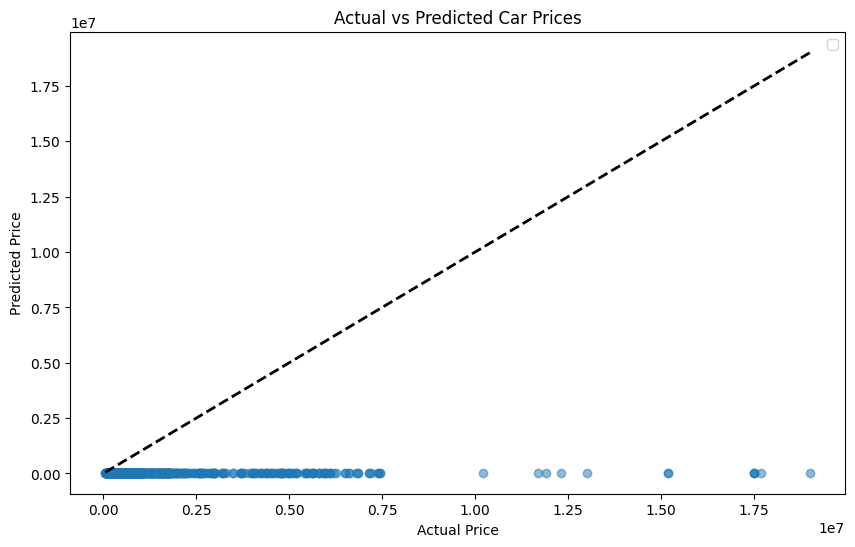

In [ ]:
# Visualize the predictions vs actual values (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, predictions, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.legend()
plt.show()


Starting training with two hidden layers...


<ipython-input-3-c905775372e6>:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1000/15000, Loss: 0.0139
Epoch 2000/15000, Loss: 0.0139
Epoch 3000/15000, Loss: 0.0139
Epoch 4000/15000, Loss: 0.0139
Epoch 5000/15000, Loss: 0.0139
Epoch 6000/15000, Loss: 0.0139
Epoch 7000/15000, Loss: 0.0139
Epoch 8000/15000, Loss: 0.0139
Epoch 9000/15000, Loss: 0.0139
Epoch 10000/15000, Loss: 0.0139
Epoch 11000/15000, Loss: 0.0139
Epoch 12000/15000, Loss: 0.0139
Epoch 13000/15000, Loss: 0.0139
Epoch 14000/15000, Loss: 0.0139
Epoch 15000/15000, Loss: 0.0139
Training finished.

Evaluating the model on the test set...
Mean Absolute Error (MAE): 1149800.82
Mean Squared Error (MSE): 5349248889495.08
Root Mean Squared Error (RMSE): 2312844.33
R-squared (R2): -0.3283


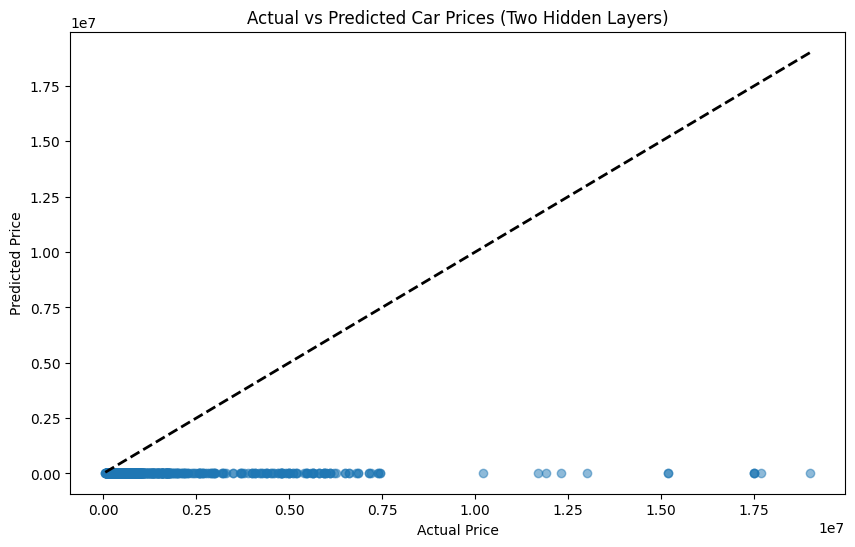

In [ ]:
# prompt: how to add 2 hidden_layers?

import matplotlib.pyplot as plt
import numpy as np
# Define the architecture of the neural network with two hidden layers
# The first layer size should match the number of features after preprocessing
# The last layer size should match the number of target variables (1 for price)
input_size = X_train_processed.shape[1]
output_size = 1
# Define the sizes of the two hidden layers
hidden_layer_1_size = 128  # First hidden layer size
hidden_layer_2_size = 64   # Second hidden layer size

layers = [input_size, hidden_layer_1_size, hidden_layer_2_size, output_size]

# Initialize and train the neural network
model = Neural_network(layers)

# Set hyperparameters
epochs = 15000 # Increased epochs
learning_rate = 0.008 # Slightly decreased learning rate

print("\nStarting training with two hidden layers...")
model.train(X_train_processed, y_train_scaled, epochs, learning_rate)
print("Training finished.")

# Step 6: Taste Your Cake (Evaluate Your Model)
print("\nEvaluating the model on the test set...")
predictions_scaled = model.predict(X_test_processed)

# Inverse transform the predictions to get them back to the original price scale
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_original = target_scaler.inverse_transform(y_test_scaled)

# Evaluate the model using metrics (e.g., Mean Absolute Error, Mean Squared Error)
mae = metrics.mean_absolute_error(y_test_original, predictions)
mse = metrics.mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_original, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")

# Visualize the predictions vs actual values (optional)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, predictions, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices (Two Hidden Layers)")
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2) # Diagonal line
plt.show()



The most likely reason for the loss value staying the same throughout the training epochs is that the **learning rate is too low**.

Here's why:

1.  **Small Weight Updates:** Your weights and biases are initialized with very small random values (multiplied by 0.01). When the learning rate is also very small (0.01 in your first training loop, 0.008 in the second), the updates applied during backpropagation will be minuscule.
2.  **Gradient Magnitude:** For the sigmoid activation function, the derivative `x * (1 - x)` is only large when `x` is around 0. As the outputs move away from 0 (towards 0 or 1), the gradient becomes very small. If your initial random weights result in outputs that are mostly far from 0.5 after the sigmoid activation, the gradients will be tiny.
3.  **Combination of Small Factors:** The error signal is multiplied by the learning rate, the sigmoid derivative, and the activation from the previous layer. If all these factors are small, the weight and bias updates will be so small that they don't significantly change the network's parameters. This leads to the loss function barely changing between epochs.

**How to fix it:**

Increase the `learning_rate`. Start with a larger value (e.g., 0.1 or 0.5) and see if the loss starts decreasing. You might need to experiment to find a suitable learning rate. If the learning rate is too high, the loss might oscillate or even increase.

**Other potential reasons (less likely in this specific case but good to consider):**

*   **Vanishing Gradients:** This is related to the sigmoid activation function and happens when gradients become extremely small as they are backpropagated through many layers. While your network is relatively simple (one or two hidden layers), the initial small weights and small learning rate could contribute to this effect early in training. Using activation functions like ReLU is more common now to mitigate this.
*   **Data Scaling Issues:** Although you are using `MinMaxScaler`, ensure the scaling is applied correctly to both features and the target. If there's an issue with scaling, it could also hinder learning.
*   **Numerical Stability:** Very small or very large intermediate values during calculations can lead to numerical instability, although less common with simple sigmoid and small networks.
*   **Dataset Size/Complexity:** If your dataset is very small or the relationship between features and target is highly complex, the model might struggle to learn with the given architecture and hyperparameters.
*   **Bugs in Backpropagation:** While your backpropagation code looks generally correct for a simple network, subtle errors can prevent gradients from flowing correctly.

**Recommendation:**

Start by significantly increasing the `learning_rate` and observe the loss. You might also consider adding more layers or neurons, but the learning rate is the most probable culprit for the loss being stuck.